## Оглавление:
1. Открытие и анализ таблиц
2. Расчеты
    - количество сделанных звонков и израсходованных минут разговора по месяцам;
    - количество отправленных сообщений по месяцам;
    - объем израсходованного интернет-трафика по месяцам;
    - помесячную выручку с каждого пользователя
    - дисперсия
3. Проверка гипотез
4. Общий вывод. 


In [1]:
import pandas as pd
import numpy as np
import math
import random
import scipy
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
calls = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Проект 3/Таблицы/calls.csv')
internet = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Проект 3/Таблицы/internet.csv')
messages = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Проект 3/Таблицы/messages.csv')
tariffs = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Проект 3/Таблицы/tariffs.csv')
users = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Проект 3/Таблицы/users.csv')

- Приведите данные к нужным типам;
- Найдите и исправьте ошибки в данных, если они есть.

In [3]:
#меняем формат дат
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])

По условию задачи «Мегалайн» всегда округляет секунды до минут

In [4]:
calls['duration'] = calls['duration'].apply(np.ceil)

### 2. Расчеты

Поставлена задача по расчету для каждого пользователя:
- количества сделанных звонков и израсходованных минут разговора по месяцам;
- количества отправленных сообщений по месяцам;
- объема израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [5]:
calls['months'] = calls['call_date'].dt.month
calls_pivot = calls.pivot_table(index=['user_id','months'], values='duration', aggfunc='sum')
calls_pivot = calls_pivot.reset_index()
calls_pivot=calls_pivot.rename(columns={'months':'month'})

In [6]:
messages.head()
messages['month'] = messages['message_date'].dt.month
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_pivot = messages_pivot.reset_index()
messages_pivot=messages_pivot.rename(columns={'id':'messages'})

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону.
Посчитайте объем израсходованного интернет-трафика по месяцам.

In [7]:
internet['month'] = internet['session_date'].dt.month
internet_sum = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_sum['mb_used'] = (internet_sum['mb_used']/1024).apply(np.ceil) # приводим к целому значению гигабайт, деля трафик в мб на 1024
internet_sum = internet_sum.reset_index()
internet_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  3203 non-null   int64  
 1   month    3203 non-null   int64  
 2   mb_used  3203 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 75.2 KB


Посчитайте помесячную выручку с каждого пользователя:

In [8]:
df=calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
df=df.merge(internet_sum, on=['user_id', 'month'], how='outer')
df=df.merge(users, how='left')

print(df)

      user_id  month  duration  messages  mb_used  age churn_date  \
0        1000      5     159.0      22.0      3.0   52        NaN   
1        1000      6     172.0      60.0     23.0   52        NaN   
2        1000      7     340.0      75.0     14.0   52        NaN   
3        1000      8     408.0      81.0     14.0   52        NaN   
4        1000      9     466.0      57.0     15.0   52        NaN   
...       ...    ...       ...       ...      ...  ...        ...   
3209     1489      9       NaN      32.0     17.0   35        NaN   
3210     1489     10       NaN      21.0     20.0   35        NaN   
3211     1489     11       NaN      20.0     18.0   35        NaN   
3212     1489     12       NaN      35.0     17.0   35        NaN   
3213     1476      4       NaN       NaN      1.0   50        NaN   

                 city first_name  last_name    reg_date tariff  
0           Краснодар     Рафаил  Верещагин  2018-05-25  ultra  
1           Краснодар     Рафаил  Верещаг

In [9]:
calls_pivot_reset=df.copy()
# здесь и ниже значения постоянны и берутся из условий тарифа
# в случае работы по нескольким тарифам можно настроить работу через переменную
calls_pivot_reset.loc[calls_pivot_reset['tariff'] == 'ultra', 'duration_p'] = calls_pivot_reset['duration']-3000 #остаток минут в пакете
calls_pivot_reset.loc[calls_pivot_reset['tariff'] == 'smart', 'duration_p'] = calls_pivot_reset['duration']-500

calls_pivot_reset.loc[calls_pivot_reset['tariff'] == 'ultra', 'messages_p'] = calls_pivot_reset['messages']-1000 #остаток сообщений в пакете
calls_pivot_reset.loc[calls_pivot_reset['tariff'] == 'smart', 'messages_p'] = calls_pivot_reset['messages']-50

calls_pivot_reset.loc[calls_pivot_reset['tariff'] == 'ultra', 'internet_p'] = calls_pivot_reset['mb_used']-(30720/1024) #остаток гигабайт в пакете
calls_pivot_reset.loc[calls_pivot_reset['tariff'] == 'smart', 'internet_p'] = calls_pivot_reset['mb_used']-(15360/1024)

calls_pivot_reset # итоговая таблица
# если число в duration_p и тд отрицательное, то пользователь платит только абонентскую плату
# если положительное - то в следующем шаге по этому числу будет рассчитан дополнительный доход компании

,user_id,month,duration,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,duration_p,messages_p,internet_p
0,1000,5,159.0,22.0,3.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,-2841.0,-978.0,-27.0
1,1000,6,172.0,60.0,23.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,-2828.0,-940.0,-7.0
2,1000,7,340.0,75.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,-2660.0,-925.0,-16.0
3,1000,8,408.0,81.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,-2592.0,-919.0,-16.0
4,1000,9,466.0,57.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,-2534.0,-943.0,-15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,32.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,NaN,-18.0,2.0
3210,1489,10,NaN,21.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,NaN,-29.0,5.0
3211,1489,11,NaN,20.0,18.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,NaN,-30.0,3.0
3212,1489,12,NaN,35.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,NaN,-15.0,2.0


In [10]:
calls_pivot_reset = calls_pivot_reset.fillna(0)

In [11]:
#создадим новый ДФ для более простой работы
cpr_profit=pd.DataFrame(calls_pivot_reset, columns=['user_id', 'duration_p', 'messages_p', 'internet_p', 'tariff', 'city'])

# считаем выручку за минуты
cpr_profit.loc[(cpr_profit['tariff'] == 'ultra') & (cpr_profit['duration_p'] > 0), 'duration_b'] = cpr_profit['duration_p']*1
cpr_profit.loc[(cpr_profit['tariff'] == 'smart') & (cpr_profit['duration_p'] > 0), 'duration_b'] = cpr_profit['duration_p']*3
cpr_profit['duration_b'] = cpr_profit['duration_b'].fillna(0)

# считаем выручку за сообщения 
cpr_profit.loc[(cpr_profit['tariff'] == 'ultra') & (cpr_profit['messages_p'] > 0), 'messages_b'] = cpr_profit['messages_p']*1
cpr_profit.loc[(cpr_profit['tariff'] == 'smart') & (cpr_profit['messages_p'] > 0), 'messages_b'] = cpr_profit['messages_p']*3
cpr_profit['messages_b'] = cpr_profit['messages_b'].fillna(0)

# считаем выручку за гигабайты
cpr_profit.loc[(cpr_profit['tariff'] == 'ultra') & (cpr_profit['internet_p'] > 0), 'internet_b'] = cpr_profit['internet_p']*150
cpr_profit.loc[(cpr_profit['tariff'] == 'smart') & (cpr_profit['internet_p'] > 0), 'internet_b'] = cpr_profit['internet_p']*200
cpr_profit['internet_b'] = cpr_profit['internet_b'].fillna(0)

#считаем помесячную выручку
cpr_profit.loc[(cpr_profit['tariff'] == 'ultra'), 'month_revenue'] = 1950+cpr_profit['duration_b']+cpr_profit['messages_b']+cpr_profit['internet_b']
cpr_profit.loc[(cpr_profit['tariff'] == 'smart'), 'month_revenue'] = 550+cpr_profit['duration_b']+cpr_profit['messages_b']+cpr_profit['internet_b']

print(cpr_profit)

      user_id  duration_p  messages_p  internet_p tariff             city  \
0        1000     -2841.0      -978.0       -27.0  ultra        Краснодар   
1        1000     -2828.0      -940.0        -7.0  ultra        Краснодар   
2        1000     -2660.0      -925.0       -16.0  ultra        Краснодар   
3        1000     -2592.0      -919.0       -16.0  ultra        Краснодар   
4        1000     -2534.0      -943.0       -15.0  ultra        Краснодар   
...       ...         ...         ...         ...    ...              ...   
3209     1489         0.0       -18.0         2.0  smart  Санкт-Петербург   
3210     1489         0.0       -29.0         5.0  smart  Санкт-Петербург   
3211     1489         0.0       -30.0         3.0  smart  Санкт-Петербург   
3212     1489         0.0       -15.0         2.0  smart  Санкт-Петербург   
3213     1476         0.0         0.0       -29.0  ultra           Москва   

      duration_b  messages_b  internet_b  month_revenue  
0            0.0 

In [12]:
mdu=np.ceil(cpr_profit.query('tariff == "ultra"')['month_revenue'].mean())
mds=np.ceil(cpr_profit.query('tariff == "smart"')['month_revenue'].mean())

mvu = np.ceil(cpr_profit.query('tariff == "ultra"')['month_revenue'].sum())
mvs = np.ceil(cpr_profit.query('tariff == "smart"')['month_revenue'].sum())

mu = np.ceil(cpr_profit.query('city == "Москва"')['month_revenue'].mean())
ou = np.ceil(cpr_profit.query('city != "Москва"')['month_revenue'].mean())

print(f'Средняя выручка по клиенту на Ультре составляет {mdu}, на Смарте - {mds}')
print(f'Общая выручка по клиентам на Ультре составляет {mvu}, на Смарте - {mvs}')
print(f'Средняя выручка по клиентам из Москвы составляет {mu}, из регионов - {ou}')

Средняя выручка по клиенту на Ультре составляет 2071.0, на Смарте - 1290.0
Общая выручка по клиентам на Ультре составляет 2039100.0, на Смарте - 2875351.0
Средняя выручка по клиентам из Москвы составляет 1547.0, из регионов - 1525.0


In [13]:
cpr_profit.pivot_table(index='tariff', values='month_revenue', aggfunc=['mean', 'sum'])
cpr_profit.groupby('tariff').agg(sum)

,user_id,duration_p,messages_p,internet_p,duration_b,messages_b,internet_b,month_revenue
tariff,,,,,,,,
smart,2778463,-179923.0,-21687.0,2977.0,278217.0,38784.0,1332400.0,2875351.0
ultra,1244148,-2334276.0,-746377.0,-10048.0,0.0,0.0,118350.0,2039100.0


In [14]:
# Опишите поведение клиентов оператора, исходя из выборки. 
# Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

calls_pivot_reset.pivot_table(index=['user_id', 'month'], values=['duration', 'messages', 'mb_used'], aggfunc='sum').reset_index()


,user_id,month,duration,mb_used,messages
0,1000,5,159.0,3.0,22.0
1,1000,6,172.0,23.0,60.0
2,1000,7,340.0,14.0,75.0
3,1000,8,408.0,14.0,81.0
4,1000,9,466.0,15.0,57.0
...,...,...,...,...,...
3209,1498,10,247.0,21.0,42.0
3210,1499,9,70.0,2.0,11.0
3211,1499,10,449.0,18.0,48.0
3212,1499,11,612.0,18.0,59.0


Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

In [15]:
# используя медиану определим средние по минутам, трафику и сообщениям для каждого тарифа, чтобы сформировать промежуточный вывод
sdu = int(calls_pivot_reset.query('tariff == "ultra"')['duration'].median())
mu = int(calls_pivot_reset.query('tariff == "ultra"')['messages'].median())
iu = int(calls_pivot_reset.query('tariff == "ultra"')['mb_used'].median())

sds = int(calls_pivot_reset.query('tariff == "smart"')['duration'].median())
ms = int(calls_pivot_reset.query('tariff == "smart"')['messages'].median())
iss = int(calls_pivot_reset.query('tariff == "smart"')['mb_used'].median())

print(f'Среднее количество минут, необходимое на тарифе Ультра - {sdu}, сообщений - {mu}, интернета - {iu} гигабайт')
print(f'Среднее количество минут, необходимое на тарифе Смарт - {sds}, сообщений - {ms}, интернета - {iss} гигабайт')

Среднее количество минут, необходимое на тарифе Ультра - 518, сообщений - 38, интернета - 19 гигабайт
Среднее количество минут, необходимое на тарифе Смарт - 422, сообщений - 28, интернета - 17 гигабайт


In [16]:
calls_pivot_reset.groupby('tariff')['duration', 'messages', 'mb_used'].median()

/var/folders/vr/wml9hs7s5wzchnjvgzn6ddjc0000gn/T/ipykernel_12647/670520070.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  calls_pivot_reset.groupby('tariff')['duration', 'messages', 'mb_used'].median()


,duration,messages,mb_used
tariff,,,
smart,422.0,28.0,17.0
ultra,518.0,38.0,19.0


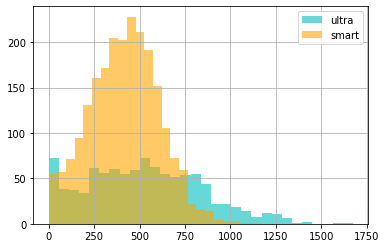

In [17]:
#гистограммы распределения среднего
calls_pivot_reset.query('tariff == "ultra"')['duration'].hist(bins=30, alpha=0.6, label='ultra', color='c')
calls_pivot_reset.query('tariff == "smart"')['duration'].hist(bins=30, alpha=0.6, label='smart', color='orange')
plt.legend()

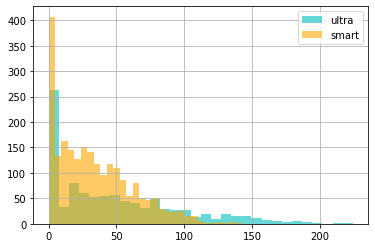

In [18]:
#гистограмма по сообщениям
calls_pivot_reset.query('tariff == "ultra"')['messages'].hist(bins=30, alpha=0.6, label='ultra', color='c')
calls_pivot_reset.query('tariff == "smart"')['messages'].hist(bins=30, alpha=0.6, label='smart', color='orange')
plt.legend()

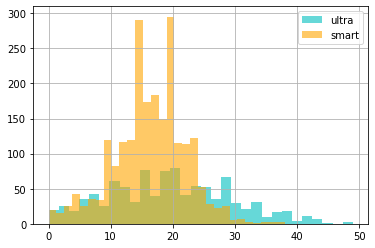

In [19]:
#гистограмма по траффику
calls_pivot_reset.query('tariff == "ultra"')['mb_used'].hist(bins=30, alpha=0.6, label='ultra', color='c')
calls_pivot_reset.query('tariff == "smart"')['mb_used'].hist(bins=30, alpha=0.6, label='smart', color='orange')
plt.legend()

Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [20]:
mean = calls_pivot_reset.pivot_table(index='user_id', values='mb_used', aggfunc='mean').mean()

# по заданию требуется считать среднюю, а не медиану, поэтому цифры будут незначительно отличаться от значений в ячейке 37

xd = calls_pivot_reset.pivot_table(index='user_id', values='duration', aggfunc='mean').mean()
xdu = calls_pivot_reset.query('tariff == "ultra"').pivot_table(index='user_id', values='duration', aggfunc='mean').mean()
xds = calls_pivot_reset.query('tariff == "smart"').pivot_table(index='user_id', values='duration', aggfunc='mean').mean()
xdup = calls_pivot_reset.query('tariff == "ultra"').pivot_table(index='user_id', values='duration', aggfunc='mean').count()
xdsp = calls_pivot_reset.query('tariff == "smart"').pivot_table(index='user_id', values='duration', aggfunc='mean').count()

print(f'Средий расход минут в общем: {int(xd[0])}, по тарифу "Ультра" - {int(xdu[0])}, по тарифу "Смарт" - {int(xds[0])}, при этом количество пользователей "Ультра" = {int(xdup[0])}, а "Смарт" = {int(xdsp[0])}')

Средий расход минут в общем: 451, по тарифу "Ультра" - 527, по тарифу "Смарт" - 419, при этом количество пользователей "Ультра" = 148, а "Смарт" = 350


In [21]:
calls_pivot_reset.pivot_table(index='tariff', values=['duration'], aggfunc='sum')

,duration
tariff,
smart,931577.0
ultra,518724.0


In [22]:

calls_pivot_reset.groupby('tariff').agg(calls_var=('duration','var'), calls_std=('duration','std')).round(2) # остальные столбцы аналогично
calls_pivot_reset.groupby('tariff').agg(calls_var=('messages','var'), calls_std=('messages','std')).round(2) # остальные столбцы аналогично
calls_pivot_reset.groupby('tariff').agg(calls_var=('mb_used','var'), calls_std=('mb_used','std')).round(2) # остальные столбцы аналогично

,calls_var,calls_std
tariff,,
smart,33.03,5.75
ultra,97.09,9.85


Промежуточные выводы: 
Согласно расчетам, можно говорить, что: 
- Средняя выручка на Ультре составляет 2219.0, на Смарте - 1166.0 рублей за пользователя
- Среднее количество минут, необходимое на тарифе Ультра - 528, сообщений - 52, интернета - 19 гигабайт
- Среднее количество минут, необходимое на тарифе Смарт - 423, сообщений - 34, интернета - 17 гигабайт
- Общий график распределения по трафику и звонкам представляет собой практически эталонное нормальное распределение, с незначительными смещениями
- Средий расход минут в общем: 457, по тарифу "Ультра" - 546, по тарифу "Смарт" - 420, при этом количество пользователей "Ультра" = 143, а "Смарт" = 349. Эти данные несколько отличны от тех, что выше, в связи с тем, что пп.1-3 считались функцией median(). 
- Средняя выручка по клиентам из Москвы составляет 1528.0, из регионов - 1471.0 рублей; 
- Дисперсия по минутам по тарифу Ультра составляет 7006426, по тарифу Смарт - 3042391
- Дисперсия по сообщениям в тарифе Ультра составляет 14, в тарифе Смарт - 14
- Дисперсия по траффику в тарифе Ультра составляет 7705, в тарифе Смарт - 3636
- Ср.кв.отклонение по минутам по тарифу Ультра составляет 2646, по тарифу Смарт - 1744
- Ср.кв.отклонение по минутам по тарифу Ультра составляет 3, по тарифу Смарт - 3
- Ср.кв.отклонение по минутам по тарифу Ультра составляет 87, по тарифу Смарт - 60

Можно сделать интересный вывод: несмотря на разительное отличие (больше чем в 2 раза) в количестве клиентов на тарифах, общая выручка по клиентам на Ультре составляет 2110018.0, на Смарте - 2591434.0. То есть, несмотря на такую разницу в количестве клиентов, общая сумма прибыли с клиентов на Ультре только на 20% ниже, чем на Смарте. 

Шаг 4. Проверьте гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

In [23]:
#создадим два массива по выручке с тарифов Ультра и Смарт

# сумма выручки по пользователям тарифа Ультра
array1 = np.array(cpr_profit.query('tariff == "ultra"').pivot_table(index='user_id', values='month_revenue', aggfunc='sum')) # 143
# сумма выручки по пользователям тарифа Смарт
array2 = np.array(cpr_profit.query('tariff == "smart"').pivot_table(index='user_id', values='month_revenue', aggfunc='sum')) # 349
#выборки не равны, отберем в список случайные значения по тарифу смарт, чтобы выборки были равны
#array21 = random.choices(array2, k=143) 

# проверка гипотезы 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
# альтернативная гипотеза: средние выручки пользователей близки/равны;
alpha = 0.05
results = scipy.stats.ttest_ind(array1, array2, equal_var = False)


if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


In [24]:
# нулевая гипотеза: средняя выручка пользователей равны:
# альтернативная гипотеза: средние выручки пользователей близки/равны;

array1 = np.array(cpr_profit.query('tariff == "ultra"')['month_revenue'])
array2 = np.array(cpr_profit.query('tariff == "smart"')['month_revenue'])
alpha = 0.05
results = scipy.stats.ttest_ind(array1, array2, equal_var = False)
print(results.pvalue, array1.mean(), array2.mean())
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.2606313931076085e-250 2070.1522842639592 1289.9735307312696
Отвергаем нулевую гипотезу


In [25]:
#средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
array11 = list(cpr_profit.query('city == "Москва"').pivot_table(index='user_id', values='month_revenue', aggfunc='sum')['month_revenue']) #99 
array12 = list(cpr_profit.query('city != "Москва"').pivot_table(index='user_id', values='month_revenue', aggfunc='sum')['month_revenue']) #393
array123 = random.choices(array12, k=99) 
alpha = 0.05
results2 = scipy.stats.ttest_ind(array11, array123, equal_var = False)

if results2.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

Не получилось отвергнуть нулевую гипотезу


In [26]:
# нулевая гипотеза: средняя выручка пользователей из Москвы и выручка пользователей из других регионов равны
# альтернативная гипотеза: средние выручки близки/равны;


array11 = np.array(cpr_profit.query('city == "Москва"')['month_revenue'])
array12 = np.array(cpr_profit.query('city != "Москва"')['month_revenue'])
alpha = 0.05
results = scipy.stats.ttest_ind(array11, array12, equal_var = False)
print(results.pvalue, array11.mean(), array12.mean())
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5257376663729298 1546.7135842880523 1524.9362274298885
Не получилось отвергнуть нулевую гипотезу


### 4. Общий вывод: 
Исходная задача была сформулирована так: на основе данных понять, какой тариф является наиболее прибыльным для компании. 

В исходных таблицах данные были представлены практически без искажений.
Был изменен формат дат, округлены "вверх" количество минут, гигабайт. 

В процессе анализа были выявлено, что, несмотря на более чем двукратный разрыв в количестве клиентов, средняя общая выручка по тарифам отличается незначительно, тариф Ультра "отстает" от Смарта примерно на 20%. При этом в среднем по пользователям, разница практически в два раза - Смарт однозначно менее прибылен. 

После проверки гипотез было выявлено, что средние выручки по тарифам Ультра и Смарт не равны, а выручка от клиентов из Москвы не отличается от выручки по клиентам из других регионов. 



